## Pytorch workflow

In [1]:
import torch
from torch import nn #nn has building blocks for neural networks: https://pytorch.org/docs/stable/nn.html
import matplotlib.pyplot as plt

torch.__version__

'2.0.0+cu118'

## 1. Data (preparing and loading)

Can be anything:
* Excel spreadsheed
* Images
* Videos
* Audio
* DNA
* Text

ML is a game of two parts:
1. Get data into numerical representation
2. Build model to learn patterns in that representation

We'll use lin reg formula to make a straight line with known parameters

In [2]:
# y = a + bX
weight = 0.7 # b
bias = 0.3 # a

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
# Split to train - validation (sometimes not needed) - test set
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split] # use sklearn split
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train)


(40, 40)

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data") # plot training data in blue

  plt.scatter(test_data, test_labels, c="g", s=4, label="Test data") # plot test data in green
  
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  
  #show legend
  plt.legend(prop={"size": 14})




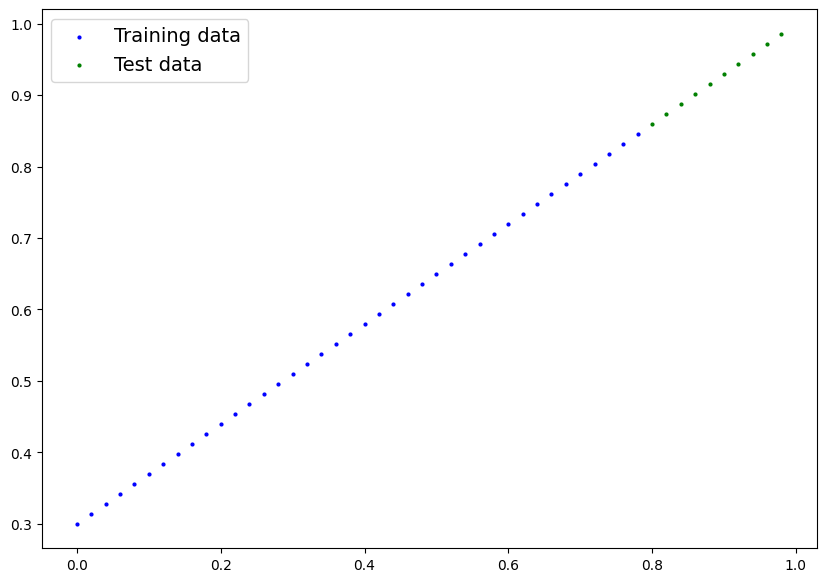

In [5]:
plot_predictions()

## 2. Build model

What model does:
* Start with random values (weight, bias)
* Look at training data and adjust those rand values to better represent ideal values that we used to create the data

How?
* Gradient descent
* Backpropagation

https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi


In [6]:
# Create lin reg model class
class LinearRegressionModel(nn.Module): # <- almost everything in pytorch inherits from this: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    super().__init__()
    # init model params - can be layers, single parameters like here, hard-coded values or functions
    self.weight = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True, #grad descent - to track gradients of this param for use with torch.autograd (this module implements gradient descent)
                                         dtype=torch.float))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor: #x is input data, needs to override this method - this is the operation the model does
    return self.weight * x + self.bias

### Pytorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a nn can be considered one)
* torch.nn.Parameter - what params our model try and learn, often a pytorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for nn modules, if you subclass it you should override forward
* torch.optim - where the optimizers for pytorch live, help with gradient descent etc.
* def forward() - all nn.Module subclasses require you to override forward()

#### Cheat sheet:
https://pytorch.org/tutorials/beginner/ptcheat.html

 ### Checking the contents of our pytorch model

 Check our model parameters using .parameters()



In [7]:
torch.manual_seed(42)

#instance of model
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### making prediction using torch.inference_mode()

To check our model's predictive power
When we pass data through our model it is going to run it through the forward method


In [9]:
with torch.inference_mode(): #before it was torch.no_grad but can be seen 
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [10]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

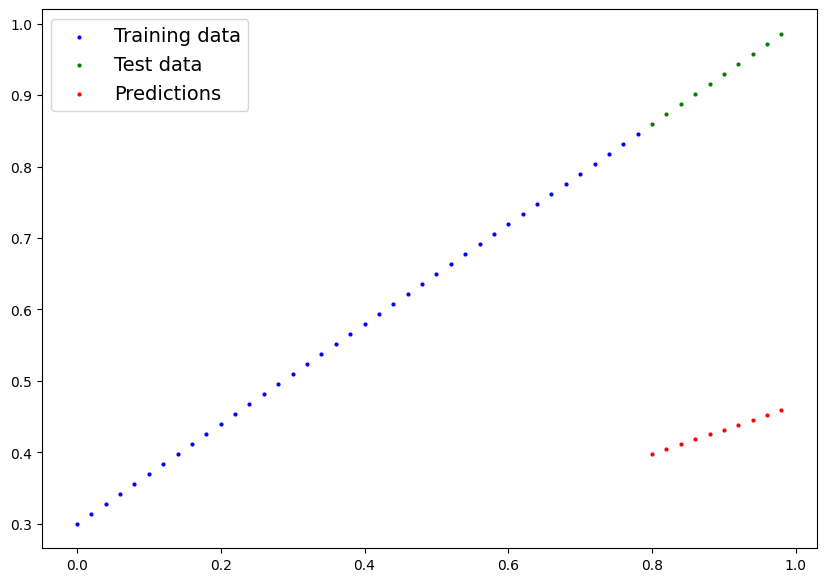

In [11]:
plot_predictions(predictions=y_preds)

## 3. Train our model

measure how poor model is -> use loss function. in torch.nn you have loss functions / criterion / cost functions

* **Loss function** - measure between prediction and ideal output, lower = better
* **Optimizer** - takes into account the loss of model and adjusts model's parameters ( weight and bias) to improve the loss function

Specifically for PyTorch:
* training loop
* testing loop


In [12]:
#Setup a loss function
loss_fn = nn.L1Loss()
#Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) #learning rate - hyperparameter


### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data and do following:
1. Forward pass / propagation - involves data moving through our model's forward functions to make predictions on data
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward  - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use optim to adjust model's parameters to try and improve the loss (**gradient descent**)



In [13]:
# an epoch is one loop through the data (this is hyperparameter because we set it ourselves)
epochs = 200
torch.manual_seed(42) 
#track values for comparison
epoch_count = []
loss_values = []
test_loss_values = []

# 0. loop through the data
for epoch in range(epochs):
  # Set the model to training mode - default mode
  model_0.train() # sets all parameters that require gradients to require gradients

  #1. Forward pass
  y_pred = model_0(X_train) 

  #2. Calculate the loss
  loss = loss_fn(y_pred, y_train) 

  #3. Optimizer zero grad
  optimizer.zero_grad() #start fresh  

  #4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  #5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop... we have to zero them above in step 3 for the next iteration of the loop

  # 1. and 2. come first, 5. must come after 4.  

  #Testing
  model_0.eval() # turns off gradient tracking for evaluation/testing (dropout/batch norm)
  with torch.inference_mode():
    epoch_count.append(epoch)
    # 1. forward pass
    test_pred = model_0(X_test)
    # 2. calculate loss
    test_loss = loss_fn(test_pred, y_test)

    loss_values.append(loss)
    test_loss_values.append(test_loss)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weight', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weight', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weight', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weight', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weight', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weight', tensor([0.5116])), ('bias', tensor([0.3788]))])
E

In [14]:
# epoch_count, loss_values, test_loss_values

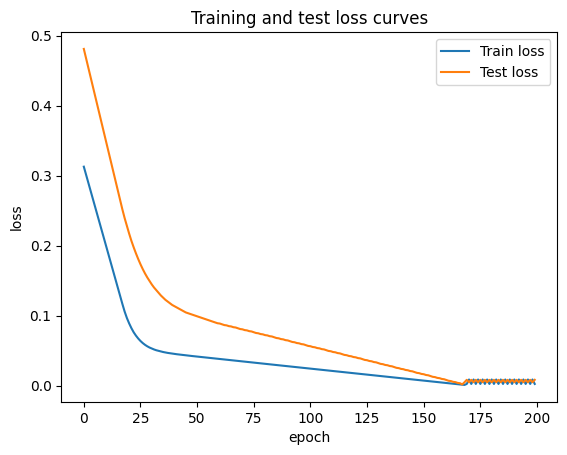

In [15]:
#plot the loss curves
plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()

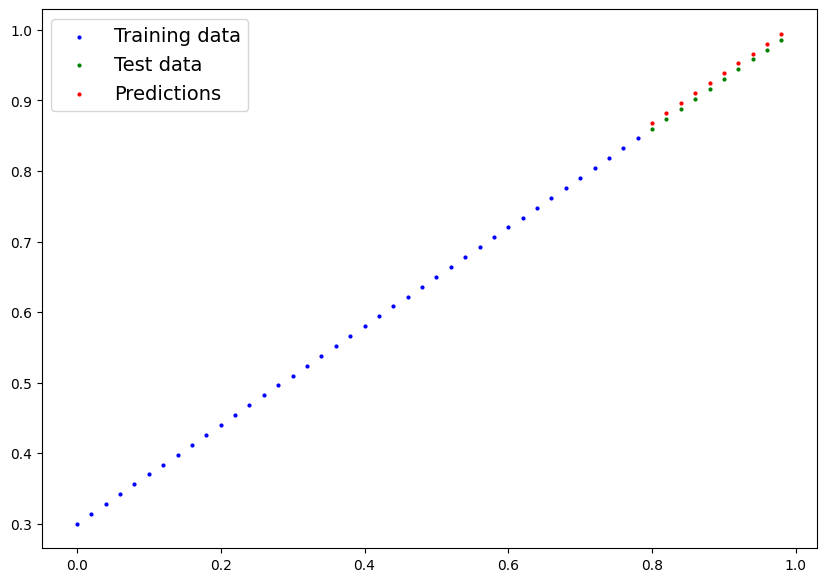

In [16]:
with torch.inference_mode():
  y_preds = model_0(X_test)
plot_predictions(predictions=y_preds)

In [17]:
#TESTING
# Our "model"
x = torch.tensor([1., 2.], requires_grad=True)
y = torch.tensor([5., 20.], requires_grad=True)

# Compute loss
loss = loss = loss_fn(y, x) 

# Compute gradient of the loss w.r.t. to the parameters  
print(x.grad)     # None
loss.backward()      
print(x.grad)     # tensor([100., 100.])

# MOdify the parameters by subtracting the gradient
optim = torch.optim.SGD([x], lr=0.001)
print(x)        # tensor([1., 2.], requires_grad=True)
optim.step()
print(x)        # tensor([0.9000, 1.9000], requires_grad=True)

None
tensor([-0.5000, -0.5000])
tensor([1., 2.], requires_grad=True)
tensor([1.0005, 2.0005], requires_grad=True)


## Saving a model in PyTorch

There are 3 main methods for saving and loading models
* `torch.save()` - saves a model in pickle format
* `torch.load()` - load saved
* `torch.nn.Module.load_state_dict()` - allows to load model's saved state dictionary  

Recommended to save/load state dict

In [18]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [19]:
# saving 
from pathlib import Path

# create models dir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_0.pth" #pt or pth
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH 

#save state dict
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

In [20]:
#create new instance of model and load saved state dict
loaded_model_0 = LinearRegressionModel()

print(loaded_model_0.state_dict())
#update new instance with saved parameters

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
print(loaded_model_0.state_dict())

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])
OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])


# Putting it all together

In [21]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.0.0+cu118'

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


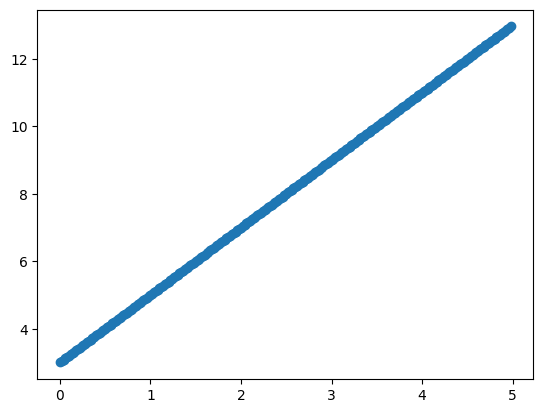

In [23]:
# Create some data using the lin reg formula y = x*weight + bias or better for example y =sin(x)*2 + 3
import math 
import numpy as np

weight = 2
bias = 3

start = 0
end = 5
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
# y = weight*np.sin(X) + bias
y = X*weight+bias
plt.scatter(X, y)


In [24]:
#split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

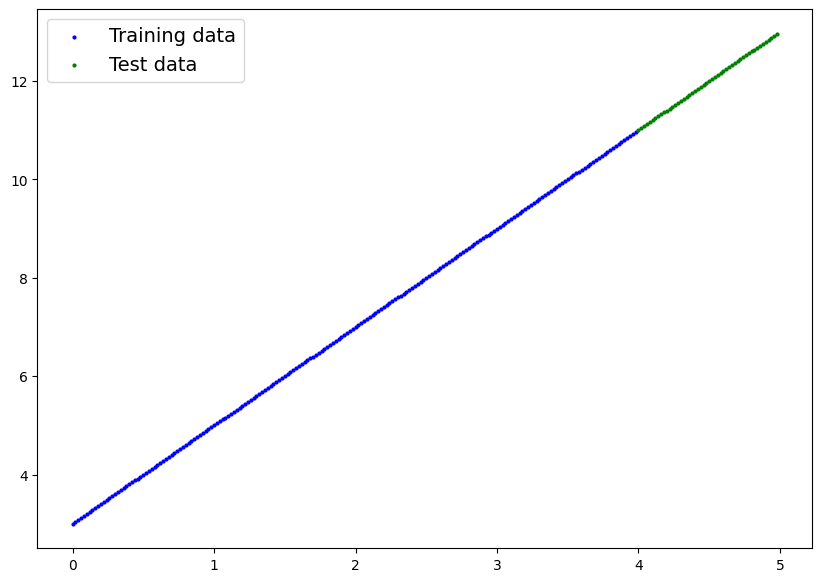

In [25]:
plot_predictions(X_train, y_train, X_test, y_test)

In [26]:
# building a pytorch linear model
class LRv2(nn.Module):
  def __init__(self):
    super().__init__()
    #now we dont init params but layers that have params in them
    #use nn.Linear() for creating model params / also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1, out_features=1)
  
  def forward(self, x):
    return self.linear_layer(x)

In [27]:
torch.manual_seed(42)
model_1 = LRv2()
model_1, model_1.state_dict()

(LRv2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [28]:
#set model to use target device
#check current device
print(next(model_1.parameters()).device)
model_1.to(device)
print(next(model_1.parameters()).device) 

cpu
cuda:0


In [29]:
#Training code
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(lr=0.01, params=model_1.parameters())

In [30]:
#put data on device (Device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [31]:
#training loop
torch.manual_seed(42)
epochs = 200

for epoch in range(epochs):
  model_1.train()

  y_pred = model_1(X_train)

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #Testing

  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)
  
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Train loss: 4.6285600662231445 | Test loss: 7.617863178253174
Epoch: 10 | Train loss: 4.13254976272583 | Test loss: 6.624351501464844
Epoch: 20 | Train loss: 3.636540412902832 | Test loss: 5.630843162536621
Epoch: 30 | Train loss: 3.140531539916992 | Test loss: 4.637335300445557
Epoch: 40 | Train loss: 2.644521951675415 | Test loss: 3.643826723098755
Epoch: 50 | Train loss: 2.148513078689575 | Test loss: 2.6503186225891113
Epoch: 60 | Train loss: 1.6525039672851562 | Test loss: 1.6568102836608887
Epoch: 70 | Train loss: 1.1564927101135254 | Test loss: 0.6632971167564392
Epoch: 80 | Train loss: 0.6624158620834351 | Test loss: 0.3171950578689575
Epoch: 90 | Train loss: 0.5449733138084412 | Test loss: 0.6676568388938904
Epoch: 100 | Train loss: 0.5228787660598755 | Test loss: 0.7499164938926697
Epoch: 110 | Train loss: 0.5067470669746399 | Test loss: 0.7647943496704102
Epoch: 120 | Train loss: 0.49135512113571167 | Test loss: 0.7541755437850952
Epoch: 130 | Train loss: 0.476057

In [32]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[2.3255]], device='cuda:0')),
             ('linear_layer.bias', tensor([2.1142], device='cuda:0'))])

In [33]:
model_1.eval() # eval mode 


with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds[:10]

tensor([[11.4161],
        [11.4626],
        [11.5091],
        [11.5556],
        [11.6021],
        [11.6487],
        [11.6952],
        [11.7417],
        [11.7882],
        [11.8347]], device='cuda:0')

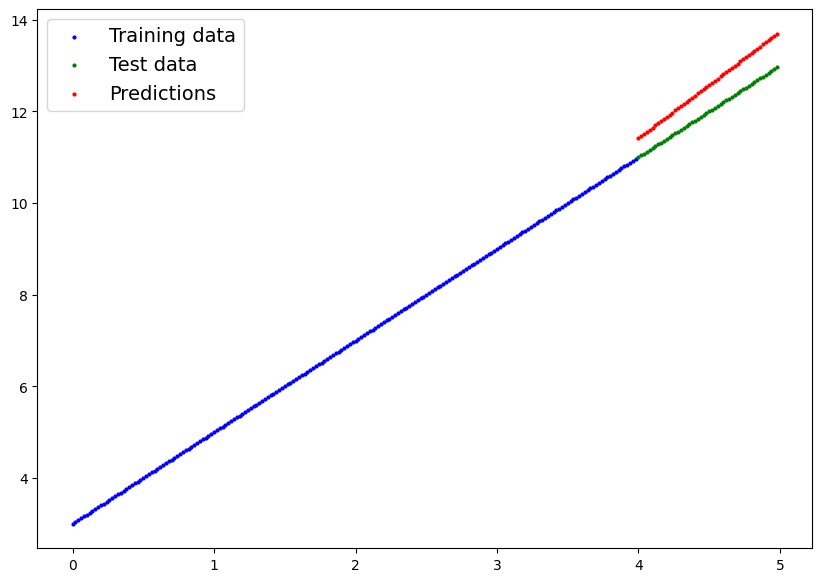

In [34]:
plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), predictions=y_preds.cpu())

device(type='cuda', index=0)